In [1]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
from monai.networks.nets import SwinUNETR
from monai.transforms import Transform
from monai.transforms import Compose, Flipd, Rotate90d, RandFlipd, RandRotate90d, RandSpatialCropd
import warnings
warnings.filterwarnings("ignore")
from monai.data import CacheDataset, DataLoader
import torch.nn.functional as F 
import zipfile
from tqdm import tqdm
import wandb
from datetime import datetime
### our modules
from dataset import *
from training import *
from testing import *
from preprocessing import *
from models import *
from regularization import *

# Install additional packages 
#!pip install scikit-image
#!pip install wandb
#!pip install monai==1.2.0        
#!pip install imagecodecs
#!pip install opencv-python
#!pip install einops
#!pip install pyyaml

/home/jovyan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-04-02 12:47:03.245572: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 12:47:03.263295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743590823.285800  538010 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory 

In [2]:
# Load config
with open("configs.yaml", "r") as f:
    config = yaml.safe_load(f)
    
dataset = config["dataset_paths"][config["dataset_index"]]
if not os.path.exists(dataset):
    print("Please update your data path to an existing folder.")
elif not set(["training", "test"]).issubset(set(os.listdir(dataset))):
    print("Please update your data path to the correct folder (should contain train and test folders).")
else:
    print(f"Congrats! You selected the correct folder : {dataset}")

Congrats! You selected the correct folder : ../datasets/DRIVE_dataset/datasets/


In [3]:
## configs

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if config["device"] == "auto" else torch.device(config["device"])

# Loss function
##loss_fn = DiceLoss(sigmoid=True, batch=True) if config["loss"] == "DiceLoss" else None  # Extend as needed

def create_optimizer(model):
    if config["optimizer"] == "Adam":
        return torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    elif config["optimizer"] == "AdamW":
        return torch.optim.AdamW(model.parameters(), lr=config["learning_rate"])
    return None

batch_size = config["batch_size"]
num_workers = config["num_workers"]
n_epochs = config["n_epochs"]
ensemble_models = config["ensemble_models"]
save_path = config["save_path"]
split_ratio = config["split_ratio"]

## Dataset with Monai

In [4]:
train_dict_list = build_dict_vessels(dataset, mode='training')
test_dict_list = build_dict_vessels(dataset, mode='test')

print(f'Number of samples in the training dataset: {len(train_dict_list)}')
print(f'Number of samples in the test dataset: {len(test_dict_list)}')

Number of samples in the training dataset: 20
Number of samples in the test dataset: 20


# Data Augmentation

In [5]:
# Don't run this if you don't want augmentations
train_processed_list, test_processed_list = apply_augmentation(train_dict_list, test_dict_list)

Applying augmentations
Sample from train_img_list
../datasets/DRIVE_dataset/datasets/training/images/21_training.tif
Sample from test_img_list
../datasets/DRIVE_dataset/datasets/test/images/01_test.tif
All images processed with customized CLAHE.
['../datasets/CLAHE_dataset/train/clahe_21.tif', '../datasets/CLAHE_dataset/train/clahe_22.tif', '../datasets/CLAHE_dataset/train/clahe_23.tif', '../datasets/CLAHE_dataset/train/clahe_24.tif', '../datasets/CLAHE_dataset/train/clahe_25.tif', '../datasets/CLAHE_dataset/train/clahe_26.tif', '../datasets/CLAHE_dataset/train/clahe_27.tif', '../datasets/CLAHE_dataset/train/clahe_28.tif', '../datasets/CLAHE_dataset/train/clahe_29.tif', '../datasets/CLAHE_dataset/train/clahe_30.tif', '../datasets/CLAHE_dataset/train/clahe_31.tif', '../datasets/CLAHE_dataset/train/clahe_32.tif', '../datasets/CLAHE_dataset/train/clahe_33.tif', '../datasets/CLAHE_dataset/train/clahe_34.tif', '../datasets/CLAHE_dataset/train/clahe_35.tif', '../datasets/CLAHE_dataset/train/

# DataLoaders

In [6]:
train_transforms = Compose([
    LoadVesselData()
])
train_dataset = monai.data.CacheDataset(
    data=train_dict_list, 
    transform = train_transforms
)

train_dataset, val_dataset = split_dataset(train_dataset, train_ratio=split_ratio)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=True)
print(type(train_dataloader))
validation_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=True)

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 26.70it/s]

Dataset split: 16 training samples, 4 testing samples.
<class 'monai.data.dataloader.DataLoader'>


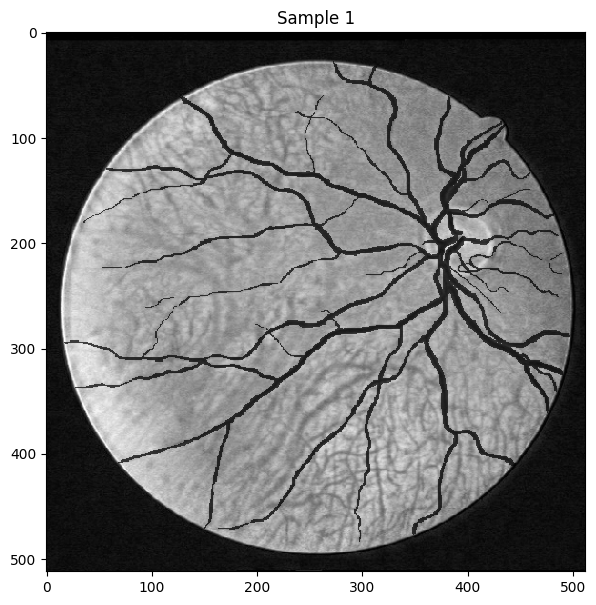

In [7]:
for i in range(1):
    visualize_vessel_sample(train_dataset[i], title=f"Sample {i+1}")

In [8]:
for batch_data in train_dataloader:
    print("Image shape:", batch_data["img"].shape)  # Expected: [batch_size, 1, 512, 512]
    break

Image shape: torch.Size([16, 1, 512, 512])


# Models

In [9]:
# Setting up the neural network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

The used device is cuda


In [10]:
models = build_ensemble_models(config, device)
print(f"Loaded {len(models)} models: {[type(m).__name__ for m in models]}")

Loaded 2 models: ['UNetWithDropout', 'UNet']


# Training

In [11]:
def from_compose_to_list(transform):
    return transform.transforms

torch.cuda.empty_cache()

# defining the dictionary mapping each model to its Dice coefficient for l;ater computation
model_dice_dict = {}

for model in models:
    print(f"Starting model: {model.__class__.__name__}")
    n = sum(p.numel() for p in model.parameters() if p.requires_grad) # number of parameters
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'], delta=0.001)


    loss_function =  monai.losses.DiceLoss(sigmoid=True, batch=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    now = datetime.now()
    now_str = now.strftime("%Y-%m-%d %H:%M:%S")

    run = wandb.init(
        project='DRIVE',
        name=now_str,
        config={
            #'models': str([type(m).__name__ for m in models]),
            'loss function': str(loss_function), 
            'lr': optimizer.param_groups[0]["lr"],
            'transform': from_compose_to_list(train_transforms),
            'batch_size': train_dataloader.batch_size,
            'layers': 5,
            'parameters': n,
            'early_stopping_patience': str(config['early_stopping_patience'])    
        }
    )

    run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

    ### training loop
    epochs = n_epochs
    train(model, epochs, train_dataloader, validation_loader, optimizer,loss_function,n,early_stopping, device)
    
    # Store the network parameters   
    os.makedirs(config['save_model'], exist_ok=True)
    torch.save(model.state_dict(), f"{config['save_model']}/{model.__class__.__name__}.pt")
    print(f"Model saved to {config['save_model']}")
    run.finish()
    
    api = wandb.Api()
    run = api.run(f"DRIVE/{run_id}")
    
    # Final Dice
    metric_fn = monai.metrics.DiceMetric()
    dice = compute_metric(validation_loader, model, metric_fn,device)
    run.summary["dice"] = dice
    run.summary.update()
    print(f"Dice on validation set: {dice:.3f}")

    model_dice_dict[model] = dice
    
    # Final Hausdorff distance
    metric_fn = monai.metrics.HausdorffDistanceMetric()
    HausdorffDistance = compute_metric(validation_loader, model, metric_fn,device)
    run.summary["HausdorffDistance"] = HausdorffDistance
    run.summary.update()
    print(f"HausdorffDistance on validation set: {HausdorffDistance:.3f}")

Starting model: UNetWithDropout


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: martidan182 (martidan182-university-of-twente) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


 28%|██▊       | 70/250 [02:26<06:37,  2.21s/it]

EarlyStopping counter: 1 / 40


 28%|██▊       | 71/250 [02:28<06:32,  2.19s/it]

EarlyStopping counter: 2 / 40


 29%|██▉       | 72/250 [02:30<06:38,  2.24s/it]

EarlyStopping counter: 3 / 40


 29%|██▉       | 73/250 [02:32<06:38,  2.25s/it]

EarlyStopping counter: 4 / 40


 30%|██▉       | 74/250 [02:35<06:37,  2.26s/it]

EarlyStopping counter: 5 / 40


 30%|███       | 75/250 [02:37<06:34,  2.26s/it]

EarlyStopping counter: 6 / 40


 30%|███       | 76/250 [02:39<06:39,  2.30s/it]

EarlyStopping counter: 7 / 40


 31%|███       | 77/250 [02:42<06:36,  2.29s/it]

EarlyStopping counter: 8 / 40


 32%|███▏      | 80/250 [02:48<06:05,  2.15s/it]

EarlyStopping counter: 1 / 40


 34%|███▎      | 84/250 [02:56<05:34,  2.02s/it]

EarlyStopping counter: 1 / 40


 34%|███▍      | 85/250 [02:58<05:27,  1.99s/it]

EarlyStopping counter: 2 / 40


 34%|███▍      | 86/250 [03:00<05:20,  1.95s/it]

EarlyStopping counter: 3 / 40


 35%|███▍      | 87/250 [03:02<05:34,  2.05s/it]

EarlyStopping counter: 4 / 40


 35%|███▌      | 88/250 [03:04<05:25,  2.01s/it]

EarlyStopping counter: 5 / 40


 36%|███▌      | 89/250 [03:06<05:19,  1.99s/it]

EarlyStopping counter: 6 / 40


 36%|███▌      | 90/250 [03:08<05:24,  2.03s/it]

EarlyStopping counter: 7 / 40


 36%|███▋      | 91/250 [03:10<05:17,  2.00s/it]

EarlyStopping counter: 8 / 40


 37%|███▋      | 92/250 [03:12<05:12,  1.98s/it]

EarlyStopping counter: 9 / 40


 38%|███▊      | 95/250 [03:18<05:05,  1.97s/it]

EarlyStopping counter: 1 / 40


 38%|███▊      | 96/250 [03:20<05:08,  2.00s/it]

EarlyStopping counter: 2 / 40


 39%|███▉      | 97/250 [03:22<05:04,  1.99s/it]

EarlyStopping counter: 3 / 40


 39%|███▉      | 98/250 [03:24<05:01,  1.98s/it]

EarlyStopping counter: 4 / 40


 40%|███▉      | 99/250 [03:26<04:55,  1.95s/it]

EarlyStopping counter: 5 / 40


 40%|████      | 100/250 [03:27<04:52,  1.95s/it]

EarlyStopping counter: 6 / 40


 40%|████      | 101/250 [03:29<04:49,  1.94s/it]

EarlyStopping counter: 7 / 40


 41%|████      | 102/250 [03:31<04:49,  1.96s/it]

EarlyStopping counter: 8 / 40


 41%|████      | 103/250 [03:33<04:47,  1.95s/it]

EarlyStopping counter: 9 / 40


 42%|████▏     | 104/250 [03:35<04:43,  1.94s/it]

EarlyStopping counter: 10 / 40


 42%|████▏     | 105/250 [03:37<04:38,  1.92s/it]

EarlyStopping counter: 11 / 40


 44%|████▎     | 109/250 [03:45<04:35,  1.96s/it]

EarlyStopping counter: 1 / 40


 46%|████▌     | 114/250 [03:55<04:24,  1.95s/it]

EarlyStopping counter: 1 / 40


 46%|████▌     | 115/250 [03:57<04:22,  1.94s/it]

EarlyStopping counter: 2 / 40


 46%|████▋     | 116/250 [03:59<04:19,  1.93s/it]

EarlyStopping counter: 3 / 40


 47%|████▋     | 117/250 [04:00<04:15,  1.92s/it]

EarlyStopping counter: 4 / 40


 47%|████▋     | 118/250 [04:02<04:12,  1.91s/it]

EarlyStopping counter: 5 / 40


 48%|████▊     | 119/250 [04:04<04:13,  1.93s/it]

EarlyStopping counter: 6 / 40


 49%|████▉     | 122/250 [04:10<04:07,  1.93s/it]

EarlyStopping counter: 1 / 40


 49%|████▉     | 123/250 [04:12<04:03,  1.92s/it]

EarlyStopping counter: 2 / 40


 51%|█████     | 128/250 [04:22<03:53,  1.92s/it]

EarlyStopping counter: 1 / 40


 52%|█████▏    | 129/250 [04:23<03:49,  1.90s/it]

EarlyStopping counter: 2 / 40


 52%|█████▏    | 130/250 [04:25<03:51,  1.93s/it]

EarlyStopping counter: 3 / 40


 52%|█████▏    | 131/250 [04:28<03:57,  1.99s/it]

EarlyStopping counter: 4 / 40


 56%|█████▌    | 139/250 [04:44<03:38,  1.97s/it]

EarlyStopping counter: 1 / 40


 56%|█████▌    | 140/250 [04:46<03:36,  1.97s/it]

EarlyStopping counter: 2 / 40


 56%|█████▋    | 141/250 [04:48<03:39,  2.01s/it]

EarlyStopping counter: 3 / 40


 57%|█████▋    | 142/250 [04:50<03:36,  2.00s/it]

EarlyStopping counter: 4 / 40


 62%|██████▏   | 156/250 [05:18<03:24,  2.18s/it]

EarlyStopping counter: 1 / 40


 63%|██████▎   | 157/250 [05:21<03:31,  2.28s/it]

EarlyStopping counter: 2 / 40


 63%|██████▎   | 158/250 [05:23<03:36,  2.36s/it]

EarlyStopping counter: 3 / 40


 64%|██████▎   | 159/250 [05:26<03:38,  2.40s/it]

EarlyStopping counter: 4 / 40


 64%|██████▍   | 160/250 [05:28<03:42,  2.47s/it]

EarlyStopping counter: 5 / 40


 64%|██████▍   | 161/250 [05:31<03:36,  2.43s/it]

EarlyStopping counter: 6 / 40


 65%|██████▍   | 162/250 [05:33<03:24,  2.33s/it]

EarlyStopping counter: 7 / 40


 65%|██████▌   | 163/250 [05:35<03:16,  2.26s/it]

EarlyStopping counter: 8 / 40


 66%|██████▌   | 164/250 [05:37<03:16,  2.28s/it]

EarlyStopping counter: 9 / 40


 66%|██████▌   | 165/250 [05:40<03:23,  2.39s/it]

EarlyStopping counter: 10 / 40


 66%|██████▋   | 166/250 [05:42<03:16,  2.34s/it]

EarlyStopping counter: 11 / 40


 67%|██████▋   | 167/250 [05:44<03:11,  2.30s/it]

EarlyStopping counter: 12 / 40


 67%|██████▋   | 168/250 [05:46<03:05,  2.26s/it]

EarlyStopping counter: 13 / 40


 68%|██████▊   | 169/250 [05:49<03:00,  2.23s/it]

EarlyStopping counter: 14 / 40


 68%|██████▊   | 170/250 [05:51<03:01,  2.27s/it]

EarlyStopping counter: 15 / 40


 68%|██████▊   | 171/250 [05:53<02:58,  2.25s/it]

EarlyStopping counter: 16 / 40


 69%|██████▉   | 172/250 [05:55<02:53,  2.22s/it]

EarlyStopping counter: 17 / 40


 69%|██████▉   | 173/250 [05:57<02:49,  2.20s/it]

EarlyStopping counter: 18 / 40


 70%|██████▉   | 174/250 [05:59<02:42,  2.14s/it]

EarlyStopping counter: 19 / 40


 70%|███████   | 175/250 [06:02<02:39,  2.13s/it]

EarlyStopping counter: 20 / 40


 70%|███████   | 176/250 [06:04<02:36,  2.11s/it]

EarlyStopping counter: 21 / 40


 71%|███████   | 177/250 [06:06<02:31,  2.08s/it]

EarlyStopping counter: 22 / 40


 71%|███████   | 178/250 [06:08<02:27,  2.05s/it]

EarlyStopping counter: 23 / 40


 72%|███████▏  | 179/250 [06:10<02:23,  2.03s/it]

EarlyStopping counter: 24 / 40


 72%|███████▏  | 180/250 [06:12<02:22,  2.03s/it]

EarlyStopping counter: 25 / 40


 72%|███████▏  | 181/250 [06:14<02:18,  2.00s/it]

EarlyStopping counter: 26 / 40


 73%|███████▎  | 182/250 [06:15<02:14,  1.98s/it]

EarlyStopping counter: 27 / 40


 73%|███████▎  | 183/250 [06:17<02:11,  1.97s/it]

EarlyStopping counter: 28 / 40


 74%|███████▎  | 184/250 [06:19<02:10,  1.98s/it]

EarlyStopping counter: 29 / 40


 74%|███████▍  | 185/250 [06:21<02:09,  1.99s/it]

EarlyStopping counter: 30 / 40


 74%|███████▍  | 186/250 [06:23<02:06,  1.98s/it]

EarlyStopping counter: 31 / 40


 75%|███████▍  | 187/250 [06:25<02:04,  1.97s/it]

EarlyStopping counter: 32 / 40


 75%|███████▌  | 188/250 [06:27<02:01,  1.96s/it]

EarlyStopping counter: 33 / 40


 76%|███████▌  | 189/250 [06:29<02:00,  1.97s/it]

EarlyStopping counter: 34 / 40


 76%|███████▌  | 190/250 [06:31<01:59,  1.99s/it]

EarlyStopping counter: 35 / 40


 76%|███████▋  | 191/250 [06:33<01:56,  1.98s/it]

EarlyStopping counter: 36 / 40


 77%|███████▋  | 192/250 [06:35<01:54,  1.98s/it]

EarlyStopping counter: 37 / 40


 77%|███████▋  | 193/250 [06:37<01:53,  1.98s/it]

EarlyStopping counter: 38 / 40


 78%|███████▊  | 194/250 [06:39<01:50,  1.97s/it]

EarlyStopping counter: 39 / 40


 78%|███████▊  | 194/250 [06:41<01:55,  2.07s/it]

EarlyStopping counter: 40 / 40
🛑 Early stopping triggered.
Model saved to ../saved_models/


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇███
mean_dice,▁▁▁▁▆██▇▇▇▇▇▇▇▇▇▇▆▇▆▇▇▇▇▇▇▇███████▇▇▇▇▇█
pixelaccuracy,▅▅▅▅▅▅▆▇███▇▇▇▆▃▃▄▄▄▃▂▁▂▃▄▄▆▆▆▆▆▆▇▇▇▇▇▆▃
train_loss,█▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁
val_loss,█████▇▇▆▆▅▅▅▅▅▅▄▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▁▁▂▂▂▂▁
epoch,194
mean_dice,0.73382
pixelaccuracy,0.94693
train_loss,0.46998
val_loss,0.47211


Dice on validation set: 0.733
HausdorffDistance on validation set: 30.501
Starting model: UNet


 18%|█▊        | 45/250 [01:09<04:59,  1.46s/it]

EarlyStopping counter: 1 / 40


 20%|█▉        | 49/250 [01:14<04:52,  1.46s/it]

EarlyStopping counter: 1 / 40


 24%|██▎       | 59/250 [01:29<04:33,  1.43s/it]

EarlyStopping counter: 1 / 40


 24%|██▍       | 61/250 [01:31<04:26,  1.41s/it]

EarlyStopping counter: 1 / 40


 25%|██▌       | 63/250 [01:34<04:21,  1.40s/it]

EarlyStopping counter: 1 / 40


 27%|██▋       | 67/250 [01:40<04:17,  1.41s/it]

EarlyStopping counter: 1 / 40


 28%|██▊       | 69/250 [01:43<04:14,  1.41s/it]

EarlyStopping counter: 1 / 40


 28%|██▊       | 70/250 [01:44<04:11,  1.40s/it]

EarlyStopping counter: 2 / 40


 28%|██▊       | 71/250 [01:45<04:12,  1.41s/it]

EarlyStopping counter: 3 / 40


 29%|██▉       | 73/250 [01:48<04:13,  1.43s/it]

EarlyStopping counter: 1 / 40


 30%|██▉       | 74/250 [01:50<04:12,  1.43s/it]

EarlyStopping counter: 2 / 40


 30%|███       | 75/250 [01:51<04:09,  1.43s/it]

EarlyStopping counter: 3 / 40


 30%|███       | 76/250 [01:53<04:07,  1.42s/it]

EarlyStopping counter: 4 / 40


 31%|███       | 78/250 [01:56<04:05,  1.43s/it]

EarlyStopping counter: 1 / 40


 32%|███▏      | 80/250 [01:58<04:00,  1.42s/it]

EarlyStopping counter: 1 / 40


 33%|███▎      | 82/250 [02:01<03:58,  1.42s/it]

EarlyStopping counter: 1 / 40


 33%|███▎      | 83/250 [02:03<03:56,  1.42s/it]

EarlyStopping counter: 2 / 40


 34%|███▎      | 84/250 [02:04<03:51,  1.40s/it]

EarlyStopping counter: 3 / 40


 34%|███▍      | 85/250 [02:05<03:49,  1.39s/it]

EarlyStopping counter: 4 / 40


 35%|███▍      | 87/250 [02:08<03:47,  1.40s/it]

EarlyStopping counter: 1 / 40


 35%|███▌      | 88/250 [02:10<03:50,  1.42s/it]

EarlyStopping counter: 2 / 40


 36%|███▌      | 89/250 [02:11<03:47,  1.41s/it]

EarlyStopping counter: 3 / 40


 36%|███▌      | 90/250 [02:12<03:43,  1.39s/it]

EarlyStopping counter: 4 / 40


 36%|███▋      | 91/250 [02:14<03:42,  1.40s/it]

EarlyStopping counter: 5 / 40


 37%|███▋      | 92/250 [02:15<03:43,  1.42s/it]

EarlyStopping counter: 6 / 40


 37%|███▋      | 93/250 [02:17<03:41,  1.41s/it]

EarlyStopping counter: 7 / 40


 38%|███▊      | 95/250 [02:19<03:36,  1.40s/it]

EarlyStopping counter: 1 / 40


 39%|███▉      | 97/250 [02:22<03:33,  1.40s/it]

EarlyStopping counter: 1 / 40


 39%|███▉      | 98/250 [02:24<03:32,  1.40s/it]

EarlyStopping counter: 2 / 40


 40%|███▉      | 99/250 [02:25<03:33,  1.42s/it]

EarlyStopping counter: 3 / 40


 40%|████      | 100/250 [02:26<03:31,  1.41s/it]

EarlyStopping counter: 4 / 40


 40%|████      | 101/250 [02:28<03:28,  1.40s/it]

EarlyStopping counter: 5 / 40


 41%|████      | 102/250 [02:29<03:27,  1.40s/it]

EarlyStopping counter: 6 / 40


 41%|████      | 103/250 [02:31<03:26,  1.41s/it]

EarlyStopping counter: 7 / 40


 42%|████▏     | 104/250 [02:32<03:24,  1.40s/it]

EarlyStopping counter: 8 / 40


 42%|████▏     | 105/250 [02:34<03:39,  1.52s/it]

EarlyStopping counter: 9 / 40


 42%|████▏     | 106/250 [02:35<03:36,  1.50s/it]

EarlyStopping counter: 10 / 40


 43%|████▎     | 108/250 [02:38<03:27,  1.46s/it]

EarlyStopping counter: 1 / 40


 44%|████▎     | 109/250 [02:40<03:22,  1.44s/it]

EarlyStopping counter: 2 / 40


 44%|████▍     | 110/250 [02:41<03:19,  1.42s/it]

EarlyStopping counter: 3 / 40


 44%|████▍     | 111/250 [02:42<03:17,  1.42s/it]

EarlyStopping counter: 4 / 40


 45%|████▌     | 113/250 [02:45<03:12,  1.41s/it]

EarlyStopping counter: 1 / 40


 46%|████▌     | 114/250 [02:47<03:10,  1.40s/it]

EarlyStopping counter: 2 / 40


 46%|████▌     | 115/250 [02:48<03:09,  1.40s/it]

EarlyStopping counter: 3 / 40


 46%|████▋     | 116/250 [02:50<03:28,  1.56s/it]

EarlyStopping counter: 4 / 40


 47%|████▋     | 118/250 [02:53<03:18,  1.50s/it]

EarlyStopping counter: 1 / 40


 48%|████▊     | 120/250 [02:56<03:10,  1.46s/it]

EarlyStopping counter: 1 / 40


 48%|████▊     | 121/250 [02:57<03:07,  1.45s/it]

EarlyStopping counter: 2 / 40


 49%|████▉     | 122/250 [02:58<03:03,  1.43s/it]

EarlyStopping counter: 3 / 40


 50%|█████     | 126/250 [03:05<03:08,  1.52s/it]

EarlyStopping counter: 1 / 40


 51%|█████     | 127/250 [03:06<03:03,  1.49s/it]

EarlyStopping counter: 2 / 40


 52%|█████▏    | 129/250 [03:09<02:53,  1.44s/it]

EarlyStopping counter: 1 / 40


 52%|█████▏    | 130/250 [03:10<02:51,  1.43s/it]

EarlyStopping counter: 2 / 40


 53%|█████▎    | 132/250 [03:13<02:46,  1.41s/it]

EarlyStopping counter: 1 / 40


 53%|█████▎    | 133/250 [03:15<02:43,  1.40s/it]

EarlyStopping counter: 2 / 40


 54%|█████▎    | 134/250 [03:16<02:43,  1.41s/it]

EarlyStopping counter: 3 / 40


 54%|█████▍    | 136/250 [03:19<02:42,  1.42s/it]

EarlyStopping counter: 1 / 40


 55%|█████▍    | 137/250 [03:20<02:40,  1.42s/it]

EarlyStopping counter: 2 / 40


 56%|█████▌    | 139/250 [03:23<02:34,  1.39s/it]

EarlyStopping counter: 1 / 40


 56%|█████▋    | 141/250 [03:26<02:31,  1.39s/it]

EarlyStopping counter: 1 / 40


 57%|█████▋    | 142/250 [03:27<02:28,  1.38s/it]

EarlyStopping counter: 2 / 40


 58%|█████▊    | 144/250 [03:30<02:28,  1.40s/it]

EarlyStopping counter: 1 / 40


 58%|█████▊    | 146/250 [03:33<02:27,  1.41s/it]

EarlyStopping counter: 1 / 40


 59%|█████▉    | 148/250 [03:36<02:23,  1.41s/it]

EarlyStopping counter: 1 / 40


 60%|██████    | 150/250 [03:39<02:21,  1.41s/it]

EarlyStopping counter: 1 / 40


 61%|██████    | 152/250 [03:41<02:19,  1.42s/it]

EarlyStopping counter: 1 / 40


 61%|██████    | 153/250 [03:43<02:17,  1.41s/it]

EarlyStopping counter: 2 / 40


 62%|██████▏   | 154/250 [03:44<02:14,  1.40s/it]

EarlyStopping counter: 3 / 40


 62%|██████▏   | 156/250 [03:47<02:11,  1.40s/it]

EarlyStopping counter: 1 / 40


 63%|██████▎   | 157/250 [03:48<02:10,  1.40s/it]

EarlyStopping counter: 2 / 40


 64%|██████▎   | 159/250 [03:51<02:07,  1.40s/it]

EarlyStopping counter: 1 / 40


 64%|██████▍   | 160/250 [03:53<02:06,  1.41s/it]

EarlyStopping counter: 2 / 40


 64%|██████▍   | 161/250 [03:54<02:04,  1.40s/it]

EarlyStopping counter: 3 / 40


 65%|██████▌   | 163/250 [03:57<02:01,  1.40s/it]

EarlyStopping counter: 1 / 40


 66%|██████▌   | 165/250 [04:00<02:00,  1.42s/it]

EarlyStopping counter: 1 / 40


 67%|██████▋   | 167/250 [04:02<01:56,  1.41s/it]

EarlyStopping counter: 1 / 40


 68%|██████▊   | 169/250 [04:05<01:55,  1.42s/it]

EarlyStopping counter: 1 / 40


 68%|██████▊   | 171/250 [04:08<01:52,  1.42s/it]

EarlyStopping counter: 1 / 40


 70%|███████   | 175/250 [04:14<01:47,  1.43s/it]

EarlyStopping counter: 1 / 40


 71%|███████   | 177/250 [04:17<01:42,  1.41s/it]

EarlyStopping counter: 1 / 40


 72%|███████▏  | 179/250 [04:20<01:40,  1.41s/it]

EarlyStopping counter: 1 / 40


 72%|███████▏  | 181/250 [04:22<01:35,  1.39s/it]

EarlyStopping counter: 1 / 40


 73%|███████▎  | 182/250 [04:24<01:35,  1.40s/it]

EarlyStopping counter: 2 / 40


 74%|███████▎  | 184/250 [04:26<01:31,  1.39s/it]

EarlyStopping counter: 1 / 40


 74%|███████▍  | 185/250 [04:28<01:31,  1.41s/it]

EarlyStopping counter: 2 / 40


 75%|███████▍  | 187/250 [04:31<01:28,  1.40s/it]

EarlyStopping counter: 1 / 40


 75%|███████▌  | 188/250 [04:32<01:26,  1.40s/it]

EarlyStopping counter: 2 / 40


 76%|███████▌  | 190/250 [04:35<01:25,  1.42s/it]

EarlyStopping counter: 1 / 40


 76%|███████▋  | 191/250 [04:36<01:23,  1.42s/it]

EarlyStopping counter: 2 / 40


 77%|███████▋  | 193/250 [04:39<01:19,  1.39s/it]

EarlyStopping counter: 1 / 40


 78%|███████▊  | 195/250 [04:42<01:17,  1.40s/it]

EarlyStopping counter: 1 / 40


 79%|███████▉  | 197/250 [04:45<01:15,  1.42s/it]

EarlyStopping counter: 1 / 40


 80%|███████▉  | 199/250 [04:48<01:11,  1.40s/it]

EarlyStopping counter: 1 / 40


 80%|████████  | 200/250 [04:49<01:09,  1.40s/it]

EarlyStopping counter: 2 / 40


 81%|████████  | 202/250 [04:52<01:07,  1.42s/it]

EarlyStopping counter: 1 / 40


 82%|████████▏ | 204/250 [04:55<01:04,  1.40s/it]

EarlyStopping counter: 1 / 40


 83%|████████▎ | 208/250 [05:00<01:00,  1.43s/it]

EarlyStopping counter: 1 / 40


 84%|████████▍ | 210/250 [05:03<00:56,  1.41s/it]

EarlyStopping counter: 1 / 40


 85%|████████▍ | 212/250 [05:06<00:58,  1.54s/it]

EarlyStopping counter: 1 / 40


 85%|████████▌ | 213/250 [05:08<00:54,  1.48s/it]

EarlyStopping counter: 2 / 40


 86%|████████▌ | 214/250 [05:09<00:52,  1.46s/it]

EarlyStopping counter: 3 / 40


 86%|████████▋ | 216/250 [05:12<00:48,  1.42s/it]

EarlyStopping counter: 1 / 40


 87%|████████▋ | 218/250 [05:15<00:44,  1.40s/it]

EarlyStopping counter: 1 / 40


 88%|████████▊ | 220/250 [05:17<00:42,  1.40s/it]

EarlyStopping counter: 1 / 40


 89%|████████▉ | 223/250 [05:22<00:38,  1.44s/it]

EarlyStopping counter: 1 / 40


 90%|█████████ | 225/250 [05:25<00:34,  1.40s/it]

EarlyStopping counter: 1 / 40


 90%|█████████ | 226/250 [05:26<00:33,  1.39s/it]

EarlyStopping counter: 2 / 40


 91%|█████████ | 227/250 [05:27<00:31,  1.39s/it]

EarlyStopping counter: 3 / 40


 91%|█████████ | 228/250 [05:29<00:30,  1.38s/it]

EarlyStopping counter: 4 / 40


 92%|█████████▏| 230/250 [05:31<00:27,  1.37s/it]

EarlyStopping counter: 1 / 40


 93%|█████████▎| 232/250 [05:34<00:25,  1.44s/it]

EarlyStopping counter: 1 / 40


 93%|█████████▎| 233/250 [05:36<00:24,  1.42s/it]

EarlyStopping counter: 2 / 40


 95%|█████████▌| 238/250 [05:43<00:16,  1.37s/it]

EarlyStopping counter: 1 / 40


 96%|█████████▌| 239/250 [05:44<00:15,  1.37s/it]

EarlyStopping counter: 2 / 40


 96%|█████████▋| 241/250 [05:47<00:12,  1.38s/it]

EarlyStopping counter: 1 / 40


 97%|█████████▋| 243/250 [05:50<00:09,  1.38s/it]

EarlyStopping counter: 1 / 40


 98%|█████████▊| 244/250 [05:51<00:08,  1.37s/it]

EarlyStopping counter: 2 / 40


 98%|█████████▊| 245/250 [05:52<00:06,  1.37s/it]

EarlyStopping counter: 3 / 40


 99%|█████████▉| 247/250 [05:55<00:04,  1.36s/it]

EarlyStopping counter: 1 / 40


100%|██████████| 250/250 [05:59<00:00,  1.44s/it]

Model saved to ../saved_models/


epoch,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███
mean_dice,▂▂▁▄▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
pixelaccuracy,▃▁▂▄▄▇▇▇▇▇▇▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,███▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁
val_loss,█████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁
epoch,249
mean_dice,0.60827
pixelaccuracy,0.93339
train_loss,0.47472
val_loss,0.62878


Dice on validation set: 0.624
HausdorffDistance on validation set: 35.124


# Test

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 172.87it/s]


Test Image dtype: torch.float32
Test Image shape: torch.Size([1, 1, 512, 512])


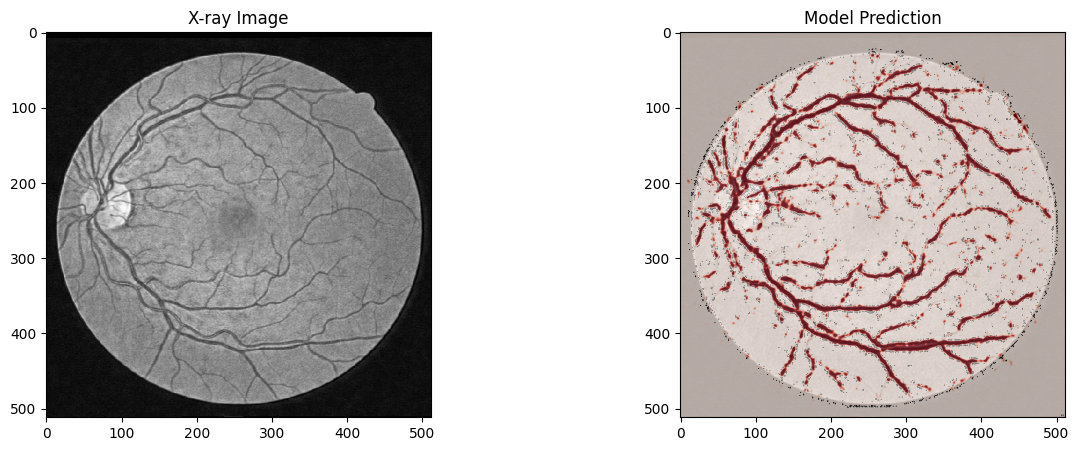

In [13]:
# Test dataset for now obtained from the training one (train_dict_list in monai.data.CacheDataset to obtain test_dataset) bacause the test dataset does not have useful masks
test_transform = monai.transforms.Compose([
    LoadVesselData(),  # ensures float32
    #monai.transforms.AddChanneld(keys=['img'])   #, 'mask']),
        #monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        #monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']),
    ###monai.transforms.EnsureTyped(keys=['img', 'mask'], dtype=torch.float32),  # Explicitly convert
])


test_dataset = monai.data.CacheDataset(test_dict_list, transform=test_transform)
test_loader = monai.data.DataLoader(test_dataset, batch_size=1)


for sample in test_loader:
    print("Test Image dtype:", sample["img"].dtype)  # Should be torch.float32
    #print("Test Mask dtype:", sample["mask"].dtype)  # Should be torch.float32
    print("Test Image shape:", sample["img"].shape)  # Should be [1, 1, 512, 512]
    break


for sample in test_loader:
    visual_evaluation_nomask(sample, model,device)
    break

In [14]:
test_outputs = compute_test_predictions_weighted(test_loader, model_dice_dict, device)
print(f"Test set predictions computed for {len(test_outputs)} images")

Test set predictions computed for 20 images


# Export Predictions for the Grand-Challenge
https://drive.grand-challenge.org/evaluation/submissions/


In [36]:
models = config["ensemble_models"]
str_models = "___".join(models)

In [37]:
test_transform = monai.transforms.Compose([
    LoadTestData(),])

save_outputs = '/'.join(config['save_model'].split('/')[:-1])  # '../saved_outputs'
os.makedirs(save_outputs, exist_ok=True)

save_path = f"{config['save_path']}_{str_models}"
zip_filename = f"{config['zip_filename']}_{str_models}.zip"
os.makedirs(save_path, exist_ok=True)

# Save output images
for i, sample in enumerate(test_loader, 1):
    image = sample["img"].to(device)
    #print(image.shape)
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)
        binary_mask = (output > 0.5).float()

    # Resize back to original shape
    forced_size = (584, 565)  
    resized_mask = F.interpolate(binary_mask, size=forced_size, mode='nearest')
    
    # Convert to numpy for saving
    resized_mask_np = resized_mask.squeeze().cpu().numpy().astype(np.uint8) * 255
    #print(f"[{i}] Output mask shape: {resized_mask_np.shape}")

    filename = os.path.join(save_path, f"{i}.png")
    cv2.imwrite(filename, resized_mask_np)
    #print(f"Saved: {filename}")

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in os.listdir(save_path):
        if file.endswith(".png"):
            zipf.write(os.path.join(save_path, file), arcname=file)

print(f"Zip file created: {zip_filename}")

# Optionally delete images after zipping
for file in os.listdir(save_path):
    file_path = os.path.join(save_path, file)
    if file.endswith(".png") and os.path.isfile(file_path):
        os.remove(file_path)
os.rmdir(save_path)
print(f"Cleaned up image files from: {save_path}")

Zip file created: ../saved_outputs/segmentation_outputs_dropout_UNet___modified_UNet.zip
Cleaned up image files from: ../saved_outputs/output_images_dropout_UNet___modified_UNet
